In [1]:
import numpy as np
import scipy
from scipy import integrate
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import time
import seaborn as sns


In [2]:
def adjacency_matrix(N : int, spectral_radius : float = 0.9, density : float = 0.02):
    rng = np.random.default_rng(0) # Initialize the numpy random number generator
    current_time = time.time_ns()
    M = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            M[i,j] = rng.uniform(0, 1.0) if rng.uniform(0.0, 1.0) < density else 0.0
    elapsed_time = time.time_ns() - current_time 
    print("> First construction [time in s]: ", elapsed_time/1.e9)
    
    current_time = time.time_ns()
    current_spectral_radius = np.abs(np.linalg.eigvals(M)).max()
    elapsed_time = time.time_ns() - current_time 
    print("> Spectral radius computation [time in s]: ", elapsed_time/1.e9)

    M *= spectral_radius / current_spectral_radius
    return M

In [3]:
def input_weights_lu2018(N : int, m : int):
    rng = np.random.default_rng(1)
    W_in = np.zeros((N, m))
    for i in range(N):
        W_in[i,rng.choice(m)] = rng.uniform(-1.0, 1.0)
    return W_in

def input_weights_zhang2021(N : int, m : int):
    rng = np.random.default_rng(1)
    W_in = np.zeros((N, m))
    for i in range(N):
        for j in range(m):
            W_in[i,j] = rng.uniform(-1.0, 1.0)
    return W_in

In [4]:
def bias_vector(N : int):
    rng = np.random.default_rng(2) # Initialize the numpy random number generator
    bias = np.zeros(N)
    for i in range(N):
        bias[i] = rng.uniform(-1.0, 1.0)
    return bias

In [5]:
class ParameterAwareDiscreteReservoir:

    def __init__(self, N : int, m: int, gamma: float, sigma : float, spectral_radius : float = 0.9, density : float = 0.02):

        # Reservoir dimension
        self.size = N
        # Dynamical system dimension
        self.input_dim = m

        # Reservoir dynamics parameters
        self.gamma = gamma  
        self.sigma = sigma 
        
        # Construction of the adjacency matrix M following (Lu et al. 2018) and (Zhang et al. 2021)
        current_time = time.time_ns()
        self.M = adjacency_matrix(N, spectral_radius, density)
        elapsed_time = time.time_ns() - current_time
        print("Adjacency matrix construction [time in s]: ", elapsed_time/1.e9)

        # Construction of the matrix of input weights W_in following (Zhang et al. 2021)
        self.W_in = input_weights_zhang2021(N, m)

        # Construction of the bias vector 
        self.bias = bias_vector(N)

        # Set the internal state to be uninitialized
        self.r = None
        self.learned_reservoir_data = None
        self.learned_input_data = None
        self.W_out = None
        self.predicted_r = None
        self.prediction = None

    """
    forget
    """
    def forget(self):
        self.r = None
        self.learned_reservoir_data = None
        self.learned_input_data = None
        self.W_out = None
        self.predicted_r = None
        self.prediction = None


    """
    learn_data

    input_data: an array whose j-th row is the input to the reservoir at time j; the matrix should have shape (*, m)
    start_time: the starting time for integrating the dynamics
    start_learning_time: the starting time for the learning phase
    end_time: the ending time for the learning phase
    initial_r: an initial state for the reservoir
    beta: bias parameter

    This method appends the evolution of the reservoir to `self.learned_reservoir_data` and the corresponding input data to `self.learned_input_data`
    """
    def learn_data(self, input_data : np.ndarray, start_time : int, start_learning_time : int, end_time : int, initial_r: np.ndarray, beta : float):
        nrows, m = np.shape(input_data)
        assert(m == self.input_dim), "`input_data` has the wrong shape"
        assert(0 <= start_time <= start_learning_time <= end_time <= nrows), "time-range constraints are not satisfied"
        def learning_reservoir_dynamics(j : int, w : np.ndarray):
            return (1.0 - self.gamma) * w + self.gamma * np.tanh(self.M @ w + self.sigma * self.W_in @ input_data[j] + self.sigma * beta * self.bias)

        w = np.copy(initial_r)
        for j in range(start_time, start_learning_time):
            w = learning_reservoir_dynamics(j, w)

        learned_reservoir_data = np.zeros((end_time-start_learning_time, self.size))
        # We have
        #   input_data[start_learning_time], input_data[start_learning_time+1], ....
        # which should be aligned with
        #   learned_reservoir_data[0], learned_reservoir_data[1], ...
        # When we call `w = learning_reservoir_dynamics(j, w)` then the new w is associated to input_data[j+1]
        # and the old w is associated to input_data[j].
        # This means that for j = start_learning_data we want to make learned_reservoir_dynamics[0] to be the old w,
        # that is, we first need to make the assignment and then apply the learning map.
        for j in range(start_learning_time, end_time):
            learned_reservoir_data[j-start_learning_time,:] = w
            w = learning_reservoir_dynamics(j, w)

        if self.learned_reservoir_data is None:
            self.learned_reservoir_data = np.copy(learned_reservoir_data)
        else:
            self.learned_reservoir_data = np.vstack([self.learned_reservoir_data, np.copy(learned_reservoir_data)])

        if self.learned_input_data is None:
            self.learned_input_data = input_data[start_learning_time:end_time]
        else:
            self.learned_input_data = np.vstack([self.learned_input_data, input_data[start_learning_time:end_time]])



    """
    train

    alpha: the regularization parameter for Ridge regression

    This method sets `self.W_out`.
    """
    def train(self, alpha : float):
        assert(self.learned_input_data is not None), "No learning has been done; first use `learn_data`."

        X = np.copy(self.learned_reservoir_data)
        y = np.copy(self.learned_input_data)

        # Ridge regression
        clf = Ridge(alpha=alpha, fit_intercept=False, tol=1.e-12, solver="svd")
        clf.fit(X, y)

        self.W_out = np.copy(clf.coef_)


    """
    evolved_predicting_reservoir

    For a trained reservoir this method will autonomously evolve the reservoir starting from
    its current state and saves the integration result to `self.predicted_solution`.

    initial_data: the initial state of the system we try to predict
    initial_r: corresponding initial reservoir state
    for_time: for how much time to evolve the reservoir
    beta: bias parameter
    """
    def evolve_predicting_reservoir(self, initial_data: np.ndarray, initial_r: np.ndarray, conv_time: int, for_time : int, beta: float):
        assert(self.W_out is not None), "The reservoir must first be trained"
        mat = self. M + self.sigma * self.W_in @ self.W_out
        def predicting_reservoir_dynamics(w : np.ndarray):
            return (1.0 - self.gamma) * w + self.gamma * np.tanh(mat @ w + self.sigma * beta * self.bias)
        # perform two steps of learning
        w = np.copy(initial_r)
        for i in range(conv_time):
            w = (1.0 - self.gamma) * w + self.gamma * np.tanh(self.M @ w + self.sigma * self.W_in @ initial_data + self.sigma * beta * self.bias)
        # evolve the predicting reservoir
        self.predicted_r = np.zeros((for_time, self.size))
        for i in range(for_time):
            self.predicted_r[i,:] = w
            w = predicting_reservoir_dynamics(w)
        self.prediction = np.zeros((for_time, self.input_dim))
        self.prediction[0,:] = initial_data
        for i in range(1, for_time):
            self.prediction[i,:] = self.reservoir_state_output(self.predicted_r[i-1,:])




    """
    reservoir_state_output

    For an internal state `r` this method returns the corresponding output.
    """
    def reservoir_state_output(self, r):
        assert(self.W_out is not None), "The reservoir must first be trained"
        return self.W_out @ r


In [6]:
p=parameters_zhang2021_parameter_aware = {"N": 1000, "adjacency_matrix_density": 0.9745, "spectral_radius": 1.1273, "alpha": 0.6397, "sigma": 0.9444, "lambda": 0.019798}


# Double Pendulum

In [7]:
def double_pendulum_dynamics(t, w):
    u =  np.zeros(4)
    theta1, omega1, theta2, omega2 = w
    u[0] = omega1
    u[1] = (9*np.cos(theta1-theta2)*np.sin(theta1-theta2)*omega1**2+6*np.sin(theta1-theta2)*omega2**2 + 18*np.sin(theta1)-9*np.cos(theta1-theta2)*np.sin(theta2))/(9*np.cos(theta1-theta2)**2-16)
    u[2] = omega2
    u[3] = (24*np.sin(theta1-theta2)*omega1**2+9*np.cos(theta1-theta2)*np.sin(theta1-theta2)*omega2**2+27*np.cos(theta1-theta2)*np.sin(theta1)-24*np.sin(theta2))/(16-9*np.cos(theta1-theta2)**2)
    return u

In [ ]:
wout_set=[]
for i in range(21):
    p1=0.1*i
    for j in range(21):
        p2=0.1*j-1
        dp_sol1 = scipy.integrate.solve_ivp(double_pendulum_dynamics, [0.0, 2500.0], [0.6, 0.0, p1, p2], "DOP853", dense_output=True)
        dp_data1 = np.transpose(dp_sol1.sol(np.linspace(0.0, 2000.0, 10000)))
        rsv1 =  ParameterAwareDiscreteReservoir(p["N"], 4,p["alpha"] , p["sigma"], p["spectral_radius"] , p["adjacency_matrix_density"])
      #print("Learning")
        np.random.seed(4)
        rsv1.learn_data(dp_data1, 0, 100, 2100, np.random.uniform(-0.1, 0.1, p["N"]), 0)
        
        #print("Training")
        rsv1.train(p["lambda"])
        #print("Predicting")
        #rsv1.integrate_predicting_reservoir(1000)
        wout_set.append(rsv1.W_out)
        print(j)

In [ ]:
ws=np.array(wout_set).reshape(21,21,4,1000)

## Quasi-Periodic

predict :1.5 0

In [ ]:
z_pre = []
for i in range(4):
    for j in range(1000):
        w = []
        for m in range(21):
            for n in range(21):
                w.append(ws[m,n][i,j])
        warray = np.array(w).reshape(21,21)
        theta = np.mgrid[0:2:21j]
        omega = np.mgrid[-1:1:21j]
        interp_spline = scipy.interpolate.RectBivariateSpline(theta, omega, warray)
        z = interp_spline(1.5, 0)
        z_pre.append(z.tolist()[0][0])
z_prepre = np.array(z_pre).reshape(4,1000)

In [ ]:
dp_sol = scipy.integrate.solve_ivp(double_pendulum_dynamics, [0.0, 2500.0], [0.6, 0.0, 1.5, 0], "DOP853", dense_output=True)
dp_data = np.transpose(dp_sol.sol(np.linspace(0.0, 2000.0, 10000)))
rsv = ParameterAwareDiscreteReservoir(p["N"], 4, p["alpha"], p["sigma"], p["spectral_radius"], p["adjacency_matrix_density"])
rsv.W_out = z_prepre
rsv.evolve_predicting_reservoir([0.6,0,1.5, 0], np.random.uniform(-0.1, 0.1, p["N"]),4,400, 0)
dp_pred_one = np.copy(rsv.prediction)

In [ ]:
rsv.evolve_predicting_reservoir([0.6,0,1.5, 0], np.random.uniform(-0.1, 0.1, p["N"]),4,400, 0)
dp_pred_one = np.copy(rsv.prediction)

In [ ]:
time_range = np.arange(0,400)
idx = 0
plt.plot(time_range, dp_data[time_range,idx], "blue")
#predict_data = [rsv.prediction(j)[idx] for j in time_range]
plt.plot(time_range,dp_pred_one[:,idx], "red")

predict: 1.85, 0

In [ ]:
z_pre = []
for i in range(4):
    for j in range(1000):
        w = []
        for m in range(21):
            for n in range(21):
                w.append(ws[m,n][i,j])
        warray = np.array(w).reshape(21,21)
        theta = np.mgrid[0:2:21j]
        omega = np.mgrid[-1:1:21j]
        interp_spline = scipy.interpolate.RectBivariateSpline(theta, omega, warray)
        z = interp_spline(1.5, 0)
        z_pre.append(z.tolist()[0][0])
z_prepre = np.array(z_pre).reshape(4,1000)

In [ ]:
rsv.evolve_predicting_reservoir([0.6,0,1.85,0], np.random.uniform(-0.1, 0.1, p["N"]),4,400, 0)
dp_pred_one = np.copy(rsv.prediction)

In [ ]:
time_range = np.arange(0,400)
idx = 0
plt.plot(time_range, dp_data[time_range,idx], "blue")
#predict_data = [rsv.prediction(j)[idx] for j in time_range]
plt.plot(time_range,dp_pred_one[:,idx], "red")

## Chaotic

predict 1.84 0.58

In [ ]:
z_pre = []
for i in range(4):
    for j in range(1000):
        w = []
        for m in range(21):
            for n in range(21):
                w.append(ws[m,n][i,j])
        warray = np.array(w).reshape(21,21)
        theta = np.mgrid[0:2:21j]
        omega = np.mgrid[-1:1:21j]
        interp_spline = scipy.interpolate.RectBivariateSpline(theta, omega, warray)
        z = interp_spline(1.84,0.58)
        z_pre.append(z.tolist()[0][0])
z_prepre = np.array(z_pre).reshape(4,1000)
dp_sol = scipy.integrate.solve_ivp(double_pendulum_dynamics, [0.0, 2500.0], [0.6, 0.0, 1.84 ,0.58], "DOP853", dense_output=True)
dp_data = np.transpose(dp_sol.sol(np.linspace(0.0, 2000.0, 10000)))
rsv = ParameterAwareDiscreteReservoir(p["N"], 4, p["alpha"], p["sigma"], p["spectral_radius"], p["adjacency_matrix_density"])
rsv.W_out = z_prepre

In [ ]:
rsv.evolve_predicting_reservoir([0.6,0,1.84,0.58], np.random.uniform(-0.1, 0.1, p["N"]),4,400, 0)
dp_pred_one = np.copy(rsv.prediction)

In [ ]:
time_range = np.arange(0,400)
idx = 0
plt.plot(time_range, dp_data[time_range,idx], "blue")
#predict_data = [rsv.prediction(j)[idx] for j in time_range]
plt.plot(time_range,dp_pred_one[:,idx], "red")

predict 1.85 ,-0.43

In [ ]:
z_pre = []
for i in range(4):
    for j in range(1000):
        w = []
        for m in range(21):
            for n in range(21):
                w.append(ws[m,n][i,j])
        warray = np.array(w).reshape(21,21)
        theta = np.mgrid[0:2:21j]
        omega = np.mgrid[-1:1:21j]
        interp_spline = scipy.interpolate.RectBivariateSpline(theta, omega, warray)
        z = interp_spline(1.85,-0.43)
        z_pre.append(z.tolist()[0][0])
z_prepre = np.array(z_pre).reshape(4,1000)
dp_sol = scipy.integrate.solve_ivp(double_pendulum_dynamics, [0.0, 2500.0], [0.6, 0.0, 1.85 ,-0.43], "DOP853", dense_output=True)
dp_data = np.transpose(dp_sol.sol(np.linspace(0.0, 2000.0, 10000)))
rsv = ParameterAwareDiscreteReservoir(p["N"], 4, p["alpha"], p["sigma"], p["spectral_radius"], p["adjacency_matrix_density"])
rsv.W_out = z_prepre

In [ ]:
rsv.evolve_predicting_reservoir([0.6,0,1.85,-0.43], np.random.uniform(-0.1, 0.1, p["N"]),4,400, 0)
dp_pred_one = np.copy(rsv.prediction)

In [ ]:
time_range = np.arange(0,400)
idx = 0
plt.plot(time_range, dp_data[time_range,idx], "blue")
#predict_data = [rsv.prediction(j)[idx] for j in time_range]
plt.plot(time_range,dp_pred_one[:,idx], "red")

# Henon-Helie

In [8]:
class HH:

    def __init__(self, N : int, m: int, gamma: float, sigma : float, spectral_radius : float = 0.9, density : float = 0.02):

        # Reservoir dimension
        self.size = N
        # Dynamical system dimension
        self.input_dim = m

        # Reservoir dynamics parameters
        self.gamma = gamma  
        self.sigma = sigma 
        
        current_time = time.time_ns()
        self.M = adjacency_matrix(N, spectral_radius, density)
        elapsed_time = time.time_ns() - current_time
        print("Adjacency matrix construction [time in s]: ", elapsed_time/1.e9)

        # Construction of the matrix of input weights W_in following (Zhang et al. 2021)
        self.W_in = input_weights_zhang2021(N, m)

        # Construction of the bias vector 
        self.bias = bias_vector(N)

        # Set the internal state to be uninitialized
        self.r = None
        self.learned_reservoir_data = None
        self.learned_input_data = None
        self.W_out = None
        self.predicted_r = None
        self.prediction = None

    """
    forget
    """
    def forget(self):
        self.r = None
        self.learned_reservoir_data = None
        self.learned_input_data = None
        self.W_out = None
        self.predicted_r = None
        self.prediction = None



    def learn_data(self, input_data : np.ndarray, start_time : int, start_learning_time : int, end_time : int, initial_r: np.ndarray, beta : float):
        nrows, m = np.shape(input_data)
        assert(m == self.input_dim), "`input_data` has the wrong shape"
        assert(0 <= start_time <= start_learning_time <= end_time <= nrows), "time-range constraints are not satisfied"
        def learning_reservoir_dynamics(j : int, w : np.ndarray):
            return (- self.gamma) * w + self.gamma * np.tanh(self.M @ w + self.sigma * self.W_in @ input_data[j] + self.sigma * beta * self.bias)

        w = np.copy(initial_r)
        for j in range(start_time, start_learning_time):
            w = learning_reservoir_dynamics(j, w)

        learned_reservoir_data = np.zeros((end_time-start_learning_time, self.size))
     
        for j in range(start_learning_time, end_time):
            learned_reservoir_data[j-start_learning_time,:] = w
            w = learning_reservoir_dynamics(j, w)

        if self.learned_reservoir_data is None:
            self.learned_reservoir_data = np.copy(learned_reservoir_data)
        else:
            self.learned_reservoir_data = np.vstack([self.learned_reservoir_data, np.copy(learned_reservoir_data)])

        if self.learned_input_data is None:
            self.learned_input_data = input_data[start_learning_time:end_time]
        else:
            self.learned_input_data = np.vstack([self.learned_input_data, input_data[start_learning_time:end_time]])


    def train(self, alpha : float):
        assert(self.learned_input_data is not None), "No learning has been done; first use `learn_data`."

        X = np.copy(self.learned_reservoir_data)
        y = np.copy(self.learned_input_data)

        # Ridge regression
        clf = Ridge(alpha=alpha, fit_intercept=False, tol=1.e-12, solver="svd")
        clf.fit(X, y)

        self.W_out = np.copy(clf.coef_)


    def evolve_predicting_reservoir(self, initial_data: np.ndarray, initial_r: np.ndarray, conv_time: int, for_time : int, beta: float):
        assert(self.W_out is not None), "The reservoir must first be trained"
        mat = self. M + self.sigma * self.W_in @ self.W_out
        def predicting_reservoir_dynamics(w : np.ndarray):
            return (- self.gamma) * w + self.gamma * np.tanh(mat @ w + self.sigma * beta * self.bias)
        # perform two steps of learning
        w = np.copy(initial_r)
        for i in range(conv_time):
            w = (- self.gamma) * w + self.gamma * np.tanh(self.M @ w + self.sigma * self.W_in @ initial_data + self.sigma * beta * self.bias)
        # evolve the predicting reservoir
        self.predicted_r = np.zeros((for_time, self.size))
        for i in range(for_time):
            self.predicted_r[i,:] = w
            w = predicting_reservoir_dynamics(w)
        self.prediction = np.zeros((for_time, self.input_dim))
        self.prediction[0,:] = initial_data
        for i in range(1, for_time):
            self.prediction[i,:] = self.reservoir_state_output(self.predicted_r[i-1,:])


    def reservoir_state_output(self, r):
        assert(self.W_out is not None), "The reservoir must first be trained"
        return self.W_out @ r


In [9]:
from math import sqrt

def henon_heiles_dynamics(t, w):
    u =  np.zeros(4)
    u[0] = w[1]
    u[1] = - w[0] - 2 * w[0] * w[2]
    u[2] = w[3]
    u[3] = - w[0]**2 + w[2]**2 - w[2]
    return u

def hh_ic(E, x2, y2):
    return [0.0, sqrt(2*E-y2**2-x2**2+2/3*x2**3), x2, y2]

In [42]:
wout_set=[]
for i in range(7):
    p1=0.1*i-0.3
    for j in range(7):
        p2=0.1*j-0.3
        hh_sol1 = scipy.integrate.solve_ivp(henon_heiles_dynamics, [0.0, 720], hh_ic(1/8, p1, p2), dense_output=True)
        hh_data1 = np.transpose(hh_sol1.sol(np.linspace(0.0, 720, 3600)))
        rsv1 =  HH(1000, 4, 0.4, 0.45, 0.8, 0.4)
        np.random.seed(4)
        rsv1.learn_data(hh_data1, 0, 100, 2100, np.random.uniform(-0.1, 0.1, 1000), 0)
        rsv1.train(1)
        wout_set.append(rsv1.W_out)
        print(j)
ws=np.array(wout_set).reshape(7,7,4,1000)

> First construction [time in s]:  3.958706
> Spectral radius computation [time in s]:  0.56115
Adjacency matrix construction [time in s]:  4.520635
0
> First construction [time in s]:  3.95986
> Spectral radius computation [time in s]:  0.535995
Adjacency matrix construction [time in s]:  4.49648
1
> First construction [time in s]:  3.954862
> Spectral radius computation [time in s]:  0.529331
Adjacency matrix construction [time in s]:  4.484807
2
> First construction [time in s]:  3.930049
> Spectral radius computation [time in s]:  0.523412
Adjacency matrix construction [time in s]:  4.454167
3
> First construction [time in s]:  3.944188
> Spectral radius computation [time in s]:  0.51871
Adjacency matrix construction [time in s]:  4.463694
4
> First construction [time in s]:  3.939411
> Spectral radius computation [time in s]:  0.531558
Adjacency matrix construction [time in s]:  4.471511
5
> First construction [time in s]:  3.974798
> Spectral radius computation [time in s]:  0.58

## Periodic

hh_ic(1/8, 0.125, -0.125)

In [43]:
z_pre = []
for i in range(4):
    for j in range(1000):
        w = []
        for m in range(7):
            for n in range(7):
                w.append(ws[m,n][i,j])
        
        warray = np.array(w).reshape(7,7)
        x = np.mgrid[-0.3:0.3:7j]
        y = np.mgrid[-0.3:0.3:7j]

        interp_spline = scipy.interpolate.RectBivariateSpline(x, y, warray)

        z = interp_spline(0.125, -0.125)
        z_pre.append(z.tolist()[0][0])

z_prepre = np.array(z_pre).reshape(4,1000)

hh_sol = scipy.integrate.solve_ivp(henon_heiles_dynamics, [0.0, 720], hh_ic(1/8, 0.125, -0.125), dense_output=True)
hh_data = np.transpose(hh_sol.sol(np.linspace(0.0, 720, 3600)))

rsv = HH(1000, 4, 0.4, 0.45, 0.8, 0.4)
rsv.W_out = z_prepre

> First construction [time in s]:  3.982187
> Spectral radius computation [time in s]:  0.527862
Adjacency matrix construction [time in s]:  4.510713


In [44]:
rsv.evolve_predicting_reservoir(hh_ic(1/8, 0.125, -0.125), np.random.uniform(-0.1, 0.1, 1000), 4, 400, 0)
dp_pred_one = np.copy(rsv.prediction)

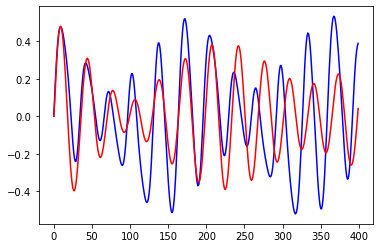

In [45]:
time_range = np.arange(0,400)
idx = 0
plt.plot(time_range, hh_data[time_range,idx], "blue")
#predict_data = [rsv.prediction(j)[idx] for j in time_range]
plt.plot(time_range,dp_pred_one[:,idx], "red")

hh_ic(1/8, 0.2, -0.05)

In [46]:
z_pre = []
for i in range(4):
    for j in range(1000):
        w = []
        for m in range(7):
            for n in range(7):
                w.append(ws[m,n][i,j])
        
        warray = np.array(w).reshape(7,7)
        x = np.mgrid[-0.3:0.3:7j]
        y = np.mgrid[-0.3:0.3:7j]

        interp_spline = scipy.interpolate.RectBivariateSpline(x, y, warray)

        z = interp_spline(0.2, -0.05)
        z_pre.append(z.tolist()[0][0])

z_prepre = np.array(z_pre).reshape(4,1000)

hh_sol = scipy.integrate.solve_ivp(henon_heiles_dynamics, [0.0, 720], hh_ic(1/8, 0.2, -0.05), dense_output=True)
hh_data = np.transpose(hh_sol.sol(np.linspace(0.0, 720, 3600)))

rsv = HH(1000, 4, 0.4, 0.45, 0.8, 0.4)
rsv.W_out = z_prepre

> First construction [time in s]:  3.951859
> Spectral radius computation [time in s]:  0.527292
Adjacency matrix construction [time in s]:  4.479869


In [47]:
rsv.evolve_predicting_reservoir(hh_ic(1/8, 0.2, -0.05), np.random.uniform(-0.1, 0.1, 1000), 4, 400, 0)
dp_pred_one = np.copy(rsv.prediction)

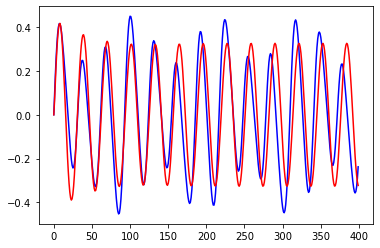

In [48]:
time_range = np.arange(0,400)
idx = 0
plt.plot(time_range, hh_data[time_range,idx], "blue")
#predict_data = [rsv.prediction(j)[idx] for j in time_range]
plt.plot(time_range,dp_pred_one[:,idx], "red")

## Chaotic

In [31]:
wout_set=[]
for i in range(7):
    p1=0.1*i-0.3
    for j in range(7):
        p2=0.1*j-0.3
        hh_sol1 = scipy.integrate.solve_ivp(henon_heiles_dynamics, [0.0, 720], hh_ic(1/6, p1, p2), dense_output=True)
        hh_data1 = np.transpose(hh_sol1.sol(np.linspace(0.0, 720, 3600)))
        rsv1 =  HH(1000, 4, 0.4, 0.45, 0.8, 0.4)
        np.random.seed(4)
        rsv1.learn_data(hh_data1, 0, 100, 2100, np.random.uniform(-0.1, 0.1, 1000), 0)
        rsv1.train(1)
        wout_set.append(rsv1.W_out)
        print(j)
ws=np.array(wout_set).reshape(7,7,4,1000)

> First construction [time in s]:  3.944544
> Spectral radius computation [time in s]:  0.535358
Adjacency matrix construction [time in s]:  4.480535
0
> First construction [time in s]:  3.980459
> Spectral radius computation [time in s]:  0.54348
Adjacency matrix construction [time in s]:  4.52451
1
> First construction [time in s]:  3.97295
> Spectral radius computation [time in s]:  0.542169
Adjacency matrix construction [time in s]:  4.515787
2
> First construction [time in s]:  3.998698
> Spectral radius computation [time in s]:  0.532678
Adjacency matrix construction [time in s]:  4.532285
3
> First construction [time in s]:  3.977767
> Spectral radius computation [time in s]:  0.548166
Adjacency matrix construction [time in s]:  4.526535
4
> First construction [time in s]:  3.99737
> Spectral radius computation [time in s]:  0.596459
Adjacency matrix construction [time in s]:  4.594629
5
> First construction [time in s]:  3.910348
> Spectral radius computation [time in s]:  0.52

hh_ic(1/6, 0.125, -0.125)

In [32]:
z_pre = []
for i in range(4):
    for j in range(1000):
        w = []
        for m in range(7):
            for n in range(7):
                w.append(ws[m,n][i,j])
        
        warray = np.array(w).reshape(7,7)
        x = np.mgrid[-0.3:0.3:7j]
        y = np.mgrid[-0.3:0.3:7j]

        interp_spline = scipy.interpolate.RectBivariateSpline(x, y, warray)

        z = interp_spline(0.125, -0.125)
        z_pre.append(z.tolist()[0][0])

z_prepre = np.array(z_pre).reshape(4,1000)

hh_sol = scipy.integrate.solve_ivp(henon_heiles_dynamics, [0.0, 720], hh_ic(1/6, 0.125, -0.125), dense_output=True)
hh_data = np.transpose(hh_sol1.sol(np.linspace(0.0, 720, 3600)))

rsv = HH(1000, 4, 0.4, 0.45, 0.8, 0.4)
rsv.W_out = z_prepre

> First construction [time in s]:  3.982342
> Spectral radius computation [time in s]:  0.529263
Adjacency matrix construction [time in s]:  4.51214


In [35]:
rsv.evolve_predicting_reservoir(hh_ic(1/6, 0.125, -0.125), np.random.uniform(-0.1, 0.1, 1000), 4, 400, 0)
dp_pred_one = np.copy(rsv.prediction)

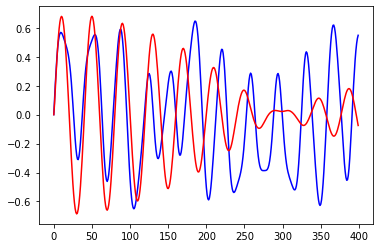

In [36]:
hh_sol1 = scipy.integrate.solve_ivp(henon_heiles_dynamics, [0.0, 720], hh_ic(1/6, 0.125, -0.125), dense_output=True)
hh_data1 = np.transpose(hh_sol1.sol(np.linspace(0.0, 720, 3600)))

time_range = np.arange(0,400)
idx = 0
plt.plot(time_range, hh_data1[time_range,idx], "blue")
plt.plot(time_range,dp_pred_one[:,idx], "red")


hh_ic(1/6, 0.2, -0.05)

In [39]:
z_pre = []
for i in range(4):
    for j in range(1000):
        w = []
        for m in range(7):
            for n in range(7):
                w.append(ws[m,n][i,j])
        
        warray = np.array(w).reshape(7,7)
        x = np.mgrid[-0.3:0.3:7j]
        y = np.mgrid[-0.3:0.3:7j]

        interp_spline = scipy.interpolate.RectBivariateSpline(x, y, warray)

        z = interp_spline(0.2, -0.05)
        z_pre.append(z.tolist()[0][0])

z_prepre = np.array(z_pre).reshape(4,1000)

hh_sol = scipy.integrate.solve_ivp(henon_heiles_dynamics, [0.0, 720], hh_ic(1/6, 0.2, -0.05), dense_output=True)
hh_data = np.transpose(hh_sol1.sol(np.linspace(0.0, 720, 3600)))

rsv = HH(1000, 4, 0.4, 0.45, 0.8, 0.4)
rsv.W_out = z_prepre

> First construction [time in s]:  3.940732
> Spectral radius computation [time in s]:  0.526792
Adjacency matrix construction [time in s]:  4.468143


In [40]:
rsv.evolve_predicting_reservoir(hh_ic(1/6, 0.2, -0.05), np.random.uniform(-0.1, 0.1, 1000), 4, 400, 0)
dp_pred_one = np.copy(rsv.prediction)

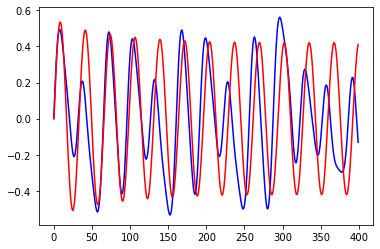

In [41]:
hh_sol1 = scipy.integrate.solve_ivp(henon_heiles_dynamics, [0.0, 720], hh_ic(1/6, 0.2, -0.05), dense_output=True)
hh_data1 = np.transpose(hh_sol1.sol(np.linspace(0.0, 720, 3600)))

time_range = np.arange(0,400)
idx = 0
plt.plot(time_range, hh_data1[time_range,idx], "blue")
plt.plot(time_range,dp_pred_one[:,idx], "red")

Try with the simple orbit:

In [37]:
hh_sol1 = scipy.integrate.solve_ivp(henon_heiles_dynamics, [0.0, 720], hh_ic(1/6, 0.02, -0.125), dense_output=True)
hh_data1 = np.transpose(hh_sol1.sol(np.linspace(0.0, 720, 3600)))
rsv1 =  HH(1000, 4, 0.4, 0.45, 0.8, 0.4)
np.random.seed(4)
rsv1.learn_data(hh_data1, 0, 100, 2100, np.random.uniform(-0.1, 0.1, 1000), 0)
rsv1.train(0.001)
rsv1.evolve_predicting_reservoir(hh_ic(1/6, 0.02, -0.125), np.random.uniform(-0.1, 0.1, 1000), 4, 400, 0)
dp_pred_one = np.copy(rsv1.prediction)

> First construction [time in s]:  3.942368
> Spectral radius computation [time in s]:  0.52303
Adjacency matrix construction [time in s]:  4.465952


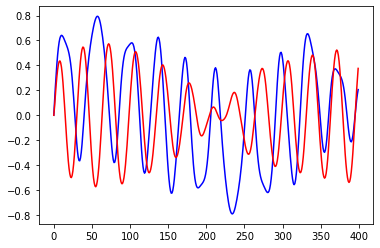

In [38]:
time_range = np.arange(0,400)
idx = 0
plt.plot(time_range, hh_data1[time_range,idx], "blue")

plt.plot(time_range,dp_pred_one[:,idx], "red")